In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya_speech.train.model.conformer as conformer
import malaya_speech.train.model.transducer as transducer
import malaya_speech
import tensorflow as tf
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/pretrained/output-base-conformer-v4.tar.gz
# !tar -zxf output-base-conformer-v4.tar.gz
# !rm output-base-conformer-v4.tar.gz

In [4]:
subwords = malaya_speech.subword.load('transducer.subword')

In [5]:
featurizer = malaya_speech.tf_featurization.STTFeaturizer(
    normalize_per_feature = True
)

In [6]:
X = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'X_placeholder')
X_len = tf.compat.v1.placeholder(tf.int32, [None], name = 'X_len_placeholder')

In [7]:
batch_size = tf.shape(X)[0]
features = tf.TensorArray(dtype = tf.float32, size = batch_size, dynamic_size = True, infer_shape = False)
features_len = tf.TensorArray(dtype = tf.int32, size = batch_size)

init_state = (0, features, features_len)

def condition(i, features, features_len):
    return i < batch_size

def body(i, features, features_len):
    f = featurizer(X[i, :X_len[i]])
    f_len = tf.shape(f)[0]
    return i + 1, features.write(i, f), features_len.write(i, f_len)

_, features, features_len = tf.while_loop(condition, body, init_state)
features_len = features_len.stack()
padded_features = tf.TensorArray(dtype = tf.float32, size = batch_size)
padded_lens = tf.TensorArray(dtype = tf.int32, size = batch_size)
maxlen = tf.reduce_max(features_len)

init_state = (0, padded_features, padded_lens)

def condition(i, padded_features, padded_lens):
    return i < batch_size

def body(i, padded_features, padded_lens):
    f = features.read(i)
    len_f = tf.shape(f)[0]
    f = tf.pad(f, [[0, maxlen - tf.shape(f)[0]], [0,0]])
    return i + 1, padded_features.write(i, f), padded_lens.write(i, len_f)

_, padded_features, padded_lens = tf.while_loop(condition, body, init_state)
padded_features = padded_features.stack()
padded_lens = padded_lens.stack()
padded_lens.set_shape((None,))
padded_features.set_shape((None, None, 80))
padded_features = tf.expand_dims(padded_features, -1)
padded_features, padded_lens

(<tf.Tensor 'ExpandDims:0' shape=(?, ?, 80, 1) dtype=float32>,
 <tf.Tensor 'TensorArrayStack_2/TensorArrayGatherV3:0' shape=(?,) dtype=int32>)

In [8]:
padded_features = tf.identity(padded_features, name = 'padded_features')
padded_lens = tf.identity(padded_lens, name = 'padded_lens')

In [9]:
config = malaya_speech.config.conformer_base_encoder_config
config['dropout'] = 0.0
conformer_model = conformer.Model(**config)
decoder_config = malaya_speech.config.conformer_base_decoder_config
decoder_config['embed_dropout'] = 0.0
transducer_model = transducer.rnn.Model(
    conformer_model, vocabulary_size = subwords.vocab_size, **decoder_config
)

In [10]:
p = tf.compat.v1.placeholder(tf.int32, [None, None], name = 'subwords')
z = tf.zeros((tf.shape(p)[0], 1),dtype=tf.int32)
c = tf.concat([z, p], axis = 1)
p_len = tf.compat.v1.placeholder(tf.int32, [None], name = 'subwords_lens')
c

<tf.Tensor 'concat:0' shape=(?, ?) dtype=int32>

In [11]:
training = True

In [12]:
logits = transducer_model([padded_features, c, p_len], training = training)
logits

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor 'transducer/transducer_joint/transducer_joint_vocab/BiasAdd:0' shape=(?, ?, ?, 1030) dtype=float32>

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(var_list = var_list)
saver.restore(sess, 'output-base-conformer/model.ckpt-500000')

INFO:tensorflow:Restoring parameters from output-base-conformer/model.ckpt-500000


In [15]:
l = padded_lens // transducer_model.encoder.conv_subsampling.time_reduction_factor
encoded = transducer_model.encoder(padded_features, training = training)
g = transducer_model._perform_greedy_alignment(encoded[0], l[0],
                                               p[0], p_len[0],
                                tf.constant(0, dtype = tf.int32),
                                transducer_model.predict_net.get_initial_state(),)
g

Hypothesis(index=<tf.Tensor 'while_2/Exit_2:0' shape=() dtype=int32>, prediction=<tf.Tensor 'TensorArrayStack_3/TensorArrayGatherV3:0' shape=(?,) dtype=int32>, states=<tf.Tensor 'while_2/Exit_4:0' shape=(1, 2, 1, 640) dtype=float32>, alignment=<tf.Tensor 'TensorArrayStack_4/TensorArrayGatherV3:0' shape=(?, 1030) dtype=float32>)

In [16]:
indices = g.prediction
minus_one = -1 * tf.ones_like(indices, dtype=tf.int32)
blank_like = 0 * tf.ones_like(indices, dtype=tf.int32)
indices = tf.where(indices == minus_one, blank_like, indices)
num_samples = tf.cast(X_len[0], dtype=tf.float32)
total_time_reduction_factor = featurizer.frame_step
stime = tf.range(0, num_samples, delta=total_time_reduction_factor, dtype=tf.float32)
stime /= tf.cast(featurizer.sample_rate, dtype=tf.float32)
stime = stime[::tf.shape(stime)[0] // tf.shape(indices)[0]]
stime.set_shape((None,))
non_blank = tf.where(tf.not_equal(indices, 0))
non_blank_transcript = tf.gather_nd(indices, non_blank)
non_blank_stime = tf.gather_nd(stime, non_blank)
non_blank_transcript = tf.identity(non_blank_transcript, name = 'non_blank_transcript')
non_blank_stime = tf.identity(non_blank_stime, name = 'non_blank_stime')

In [17]:
decoded = tf.identity(g.prediction, 'decoded')
alignment = tf.identity(g.alignment, name = 'alignment')

In [25]:
sentences = ['tangan aku disentuh lembut', 
             'tangan aku disentuh lembut', 'sebut perkataan angka']
audios = ['1.wav', '1.wav', '2.wav']
data = list(zip(audios, sentences))

In [26]:
files = [i[0] for i in data]
inputs = [malaya_speech.load(f)[0] for f in files]
padded, lens = malaya_speech.padding.sequence_1d(inputs, return_len = True)

In [27]:
targets = [malaya_speech.subword.encode(subwords, i[1]) for i in data]
targets_padded, targets_lens = malaya_speech.padding.sequence_1d(targets, return_len = True)

In [28]:
r = sess.run([decoded, alignment], feed_dict = {X: padded, X_len: lens, p: targets_padded, 
                                     p_len: targets_lens})
r

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  35,   0,   0,  18,   0, 806,  85,   0,   0,   0, 806,   0,
        265,   0,   0,   0, 336,   0,   0, 229,   0, 592,   0,   0,   0,
        513,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32),
 array([[9.99998808e-01, 1.53256496e-09, 1.82471382e-09, ...,
         7.38928196e-20, 6.74122343e-20, 1.04252894e-19],
        [9.99999404e-01, 4.13828111e-10, 6.97841340e-10, ...,
         2.52768543e-20, 2.50390415e-20, 3.80770009e-20],
        [9.99999762e-01, 1.90986435e-10, 4.53079352e-10, ...,
         1.04438831e-20, 1.19434969e-20, 1.63713487e-20],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000

In [29]:
import matplotlib.pyplot as plt

In [30]:
subwords_ = [subwords._id_to_subword(ids - 1) for ids in r[0][r[0] > 0]]
subwords_ = [s.decode() if isinstance(s, bytes) else s for s in subwords_]

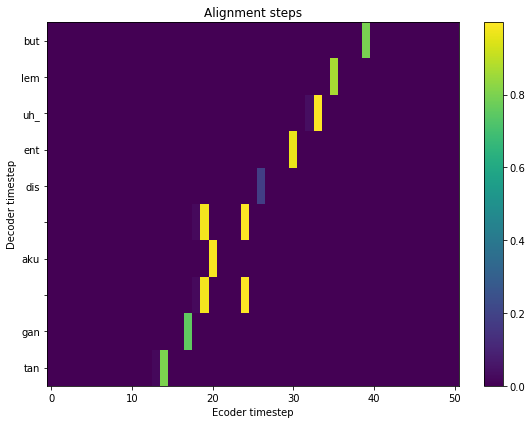

In [31]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    r[1][:, targets[0]].T,
    aspect='auto',
    origin='lower',
    interpolation='none')
ax.set_yticks(range(len(subwords_)))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(subwords_)
fig.colorbar(im, ax=ax)
xlabel = 'Ecoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Decoder timestep')
plt.tight_layout()
plt.show()

In [32]:
%%time

r = sess.run([non_blank_transcript, non_blank_stime], feed_dict = {X: padded, X_len: lens, p: targets_padded, 
                                     p_len: targets_lens})

CPU times: user 4.71 s, sys: 200 ms, total: 4.91 s
Wall time: 2.98 s


In [33]:
words, indices = [], []
for no, ids in enumerate(r[0]):
    w = subwords._id_to_subword(ids - 1)
    if type(w) == bytes:
        w = w.decode()
    words.extend([w, None])
    indices.extend([no, None])

In [34]:
def combined_indices(subwords, ids, l, reduction_factor = 160, sample_rate = 16000):
    result, temp_l, temp_r = [], [], []
    for i in range(len(subwords)):
        if ids[i] is not None:
            temp_l.append(subwords[i])
            temp_r.append(l[ids[i]])
        else:
            data = {'text': ''.join(temp_l), 
                    'start': round(temp_r[0],4), 
                    'end': round(temp_r[-1] + (reduction_factor / sample_rate), 4)}
            result.append(data)
            temp_l, temp_r = [], []
    
    if len(temp_l):
        data = {'text': ''.join(temp_l), 
                'start': round(temp_r[0],4), 
                'end': round(temp_r[-1] + (reduction_factor / sample_rate), 4)}
        result.append(data)
    
    return result

In [35]:
combined_indices(words, indices, r[1])

[{'text': 'tan', 'start': 0.56, 'end': 0.57},
 {'text': 'gan', 'start': 0.68, 'end': 0.69},
 {'text': ' ', 'start': 0.76, 'end': 0.77},
 {'text': 'aku', 'start': 0.8, 'end': 0.81},
 {'text': ' ', 'start': 0.96, 'end': 0.97},
 {'text': 'dis', 'start': 1.04, 'end': 1.05},
 {'text': 'ent', 'start': 1.2, 'end': 1.21},
 {'text': 'uh_', 'start': 1.32, 'end': 1.33},
 {'text': 'lem', 'start': 1.4, 'end': 1.41},
 {'text': 'but', 'start': 1.56, 'end': 1.57}]

In [36]:
import six
from malaya_speech.utils import text_encoder

def _trim_underscore_and_tell(token):
    if token.endswith('_'):
        return token[:-1], True
    return token, False

def decode(ids):
    ids = text_encoder.pad_decr(ids)
    subword_ids = ids
    del ids

    subwords_ = []
    prev_bytes = []
    prev_ids = []
    ids = []

    def consume_prev_bytes():
        if prev_bytes:
            subwords_.extend(prev_bytes)
            ids.extend(prev_ids)
        return [], []

    for no, subword_id in enumerate(subword_ids):
        subword = subwords._id_to_subword(subword_id)
        if isinstance(subword, six.binary_type):
            # Byte-encoded
            prev_bytes.append(subword.decode('utf-8', 'replace'))
            if subword == b' ':
                prev_ids.append(None)
            else:
                prev_ids.append(no)
        else:
            # If there were bytes previously, convert to unicode.
            prev_bytes, prev_ids = consume_prev_bytes()
            trimmed, add_space = _trim_underscore_and_tell(subword)
            ids.append(no)
            subwords_.append(trimmed)
            if add_space:
                subwords_.append(' ')
                ids.append(None)
    prev_bytes = consume_prev_bytes()

    return subwords_, ids

words, indices = decode(r[0])
len(words), len(indices)

(11, 11)

In [37]:
combined_indices(words, indices, r[1])

[{'text': 'tangan', 'start': 0.56, 'end': 0.69},
 {'text': 'aku', 'start': 0.8, 'end': 0.81},
 {'text': 'disentuh', 'start': 1.04, 'end': 1.33},
 {'text': 'lembut', 'start': 1.4, 'end': 1.57}]

In [38]:
saver = tf.train.Saver()
saver.save(sess, 'output-base-conformer-aligner/model.ckpt')

'output-base-conformer-aligner/model.ckpt'

In [39]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'placeholder' in n.name
        or 'subwords' in n.name
        or 'padded_' in n.name
        or 'non_blank' in n.name
        or 'decoded' in n.name
        or 'alignment' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
    ]
)
strings.split(',')

['X_placeholder',
 'X_len_placeholder',
 'padded_features',
 'padded_lens',
 'subwords',
 'subwords_lens',
 'transducer/transducer_prediction/transducer_prediction_embedding/embeddings',
 'non_blank_transcript',
 'non_blank_stime',
 'decoded',
 'alignment']

In [40]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [41]:
freeze_graph('output-base-conformer-aligner', strings)

INFO:tensorflow:Restoring parameters from output-base-conformer-aligner/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 561 variables.
INFO:tensorflow:Converted 561 variables to const ops.
9858 ops in the final graph.


In [42]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [43]:
g = load_graph('output-base-conformer-aligner/frozen_model.pb')

In [44]:
input_nodes = [
    'X_placeholder',
    'X_len_placeholder',
    'subwords',
    'subwords_lens'
]
output_nodes = [
    'padded_features',
    'padded_lens',
    'non_blank_transcript',
    'non_blank_stime',
    'decoded',
    'alignment'
]
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [45]:
test_sess = tf.Session(graph = g)

In [46]:
r = test_sess.run([outputs['decoded'], outputs['alignment']], feed_dict = {inputs['X_placeholder']: padded, 
                                                          inputs['X_len_placeholder']: lens,
                                                         inputs['subwords']: targets_padded,
                                                         inputs['subwords_lens']: targets_lens})

In [47]:
subwords_ = [subwords._id_to_subword(ids - 1) for ids in r[0][r[0] > 0]]
subwords_ = [s.decode() if isinstance(s, bytes) else s for s in subwords_]

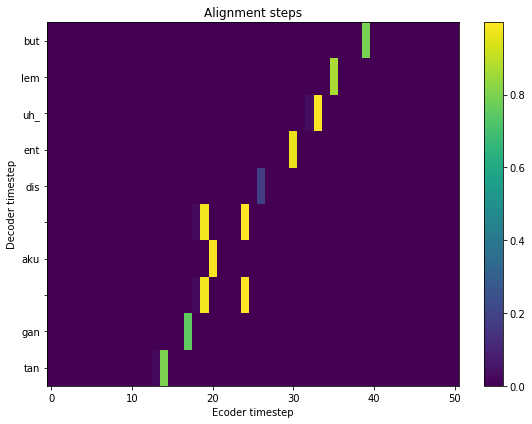

In [48]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    r[1][:, targets[0]].T,
    aspect='auto',
    origin='lower',
    interpolation='none')
ax.set_yticks(range(len(subwords_)))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(subwords_)
fig.colorbar(im, ax=ax)
xlabel = 'Ecoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Decoder timestep')
plt.tight_layout()
plt.show()

In [49]:
from tensorflow.tools.graph_transforms import TransformGraph

In [50]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

pb = 'output-base-conformer-aligner/frozen_model.pb'

input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           input_nodes,
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [51]:
b2_application_key_id = os.environ['b2_application_key_id']
b2_application_key = os.environ['b2_application_key']

In [52]:
from b2sdk.v1 import *
info = InMemoryAccountInfo()
b2_api = B2Api(info)
application_key_id = b2_application_key_id
application_key = b2_application_key
b2_api.authorize_account("production", application_key_id, application_key)
file_info = {'how': 'good-file'}
b2_bucket = b2_api.get_bucket_by_name('malaya-speech-model')

In [53]:
file = 'output-base-conformer-aligner/frozen_model.pb'
outPutname = 'force-alignment/conformer-transducer/model.pb'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [54]:
file = 'output-base-conformer-aligner/frozen_model.pb.quantized'
outPutname = 'force-alignment/conformer-transducer-quantized/model.pb'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)